 43%|████▎     | 4294/10000 [00:00<00:00, 22263.01it/s]

[-0.27614368  0.10995433 -0.0831327   0.10764787]


 23%|██▎       | 2327/10000 [00:00<00:00, 11573.27it/s]

[ 0.69013476  0.82183065 -0.09134424 -0.30064427 -0.57366892 -0.61368071
 -0.08636147  0.14287587]


 21%|██        | 2068/10000 [00:00<00:00, 20676.86it/s]

[ 0.04136388  0.00429288 -0.15301881  0.03845497  0.04700527  0.08004249
  0.04957749 -0.02152481  0.05462044 -0.5550293   0.01268194]


100%|██████████| 50/50 [00:15<00:00,  3.25it/s]


[ 0.57683931  0.44166779  0.37259054  0.36796826  0.31411149  0.33660638
  0.23504458  0.14364497  0.08538835 -0.14904683 -0.03886556 -0.01109161
  0.00693921 -0.00982231  0.034903   -0.00960423  0.02270052  0.05066304
  0.02790358  0.01924207  0.12248107  0.02686679 -0.08549018 -0.0222546
 -0.03132829 -0.0694956   0.0026603   0.02095322  0.20421457  0.47371085
  0.0166239  -0.46699802 -0.21132597]


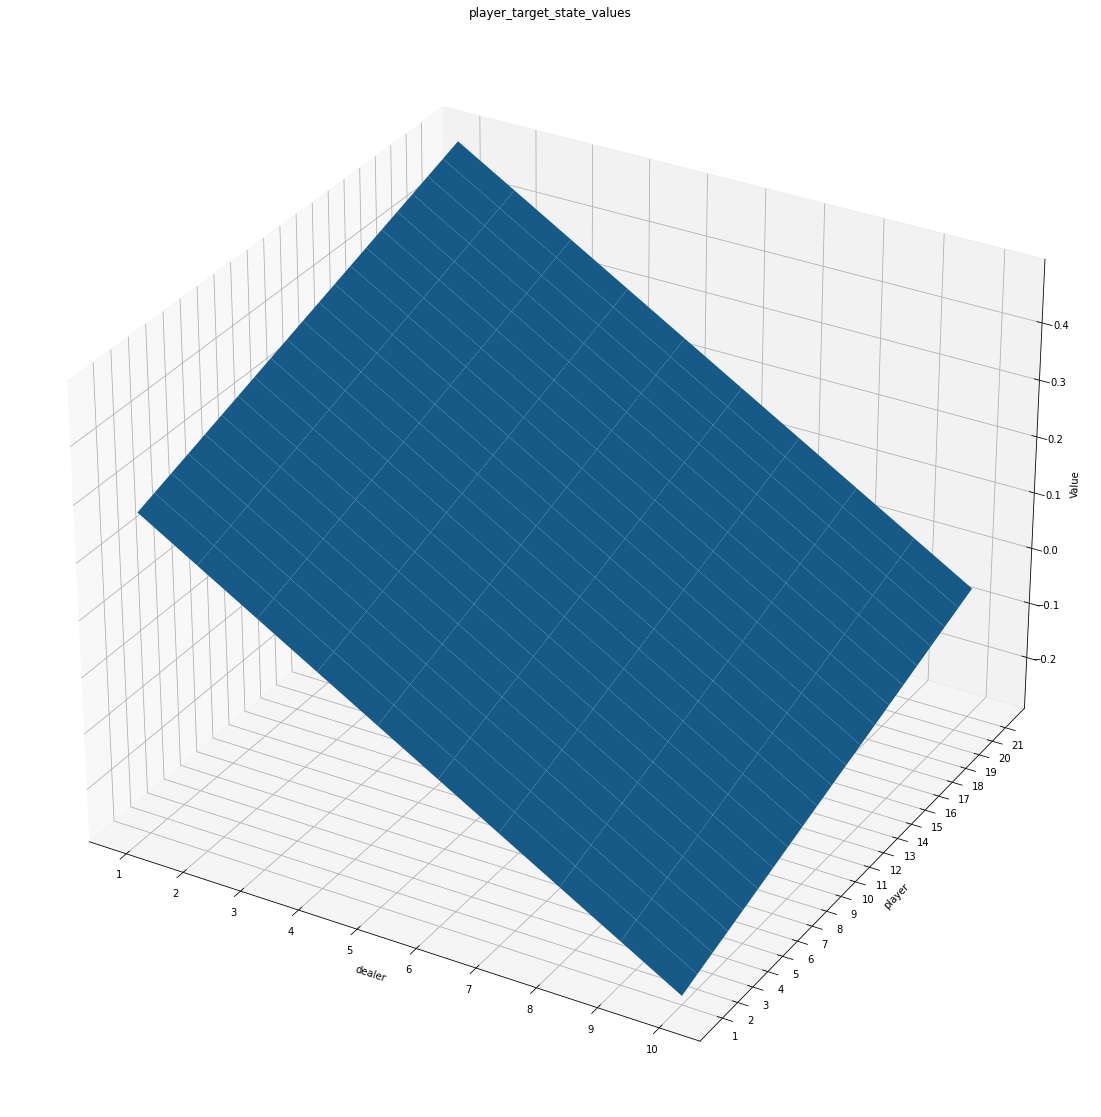

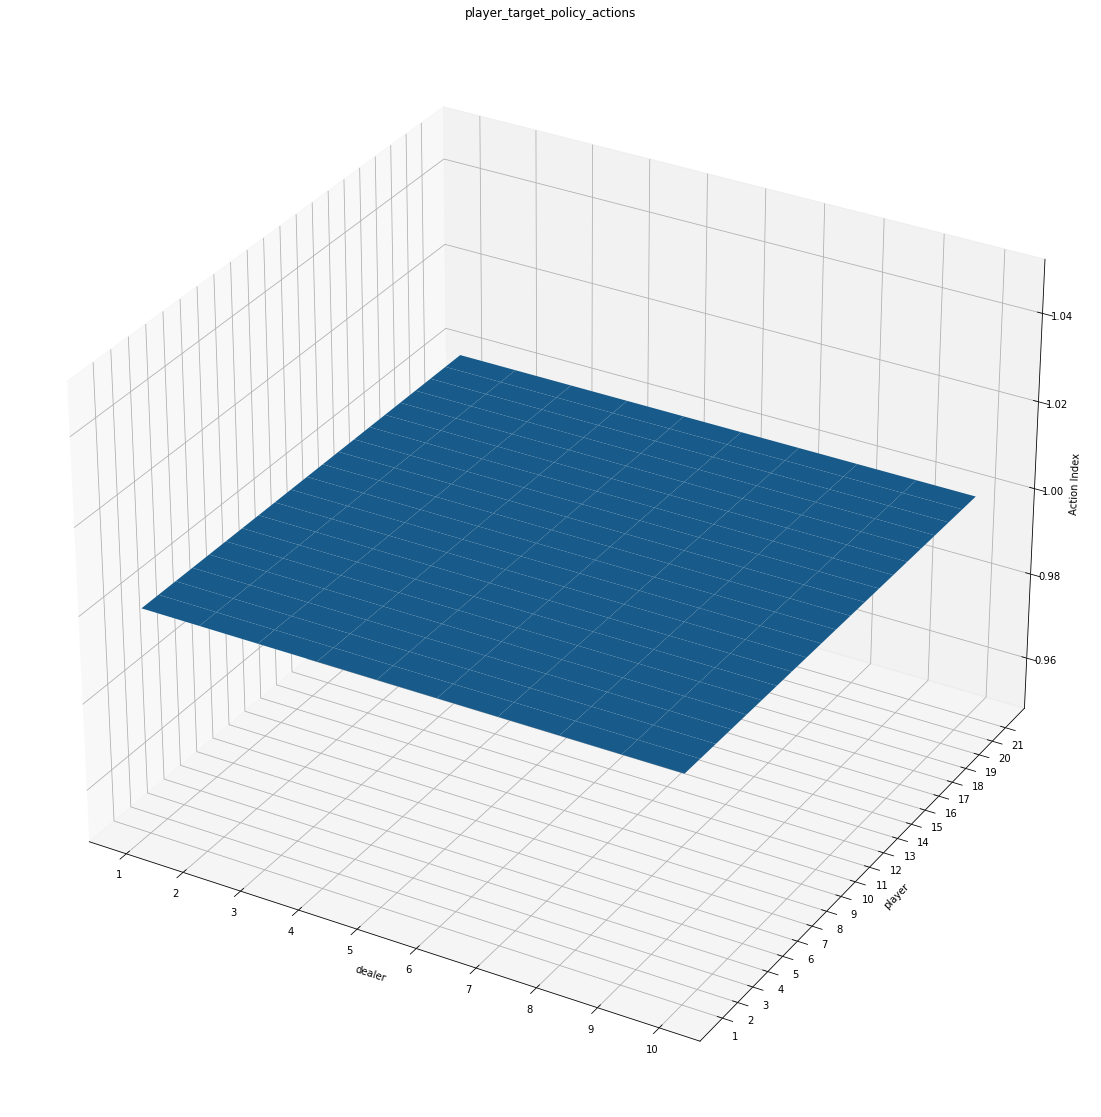

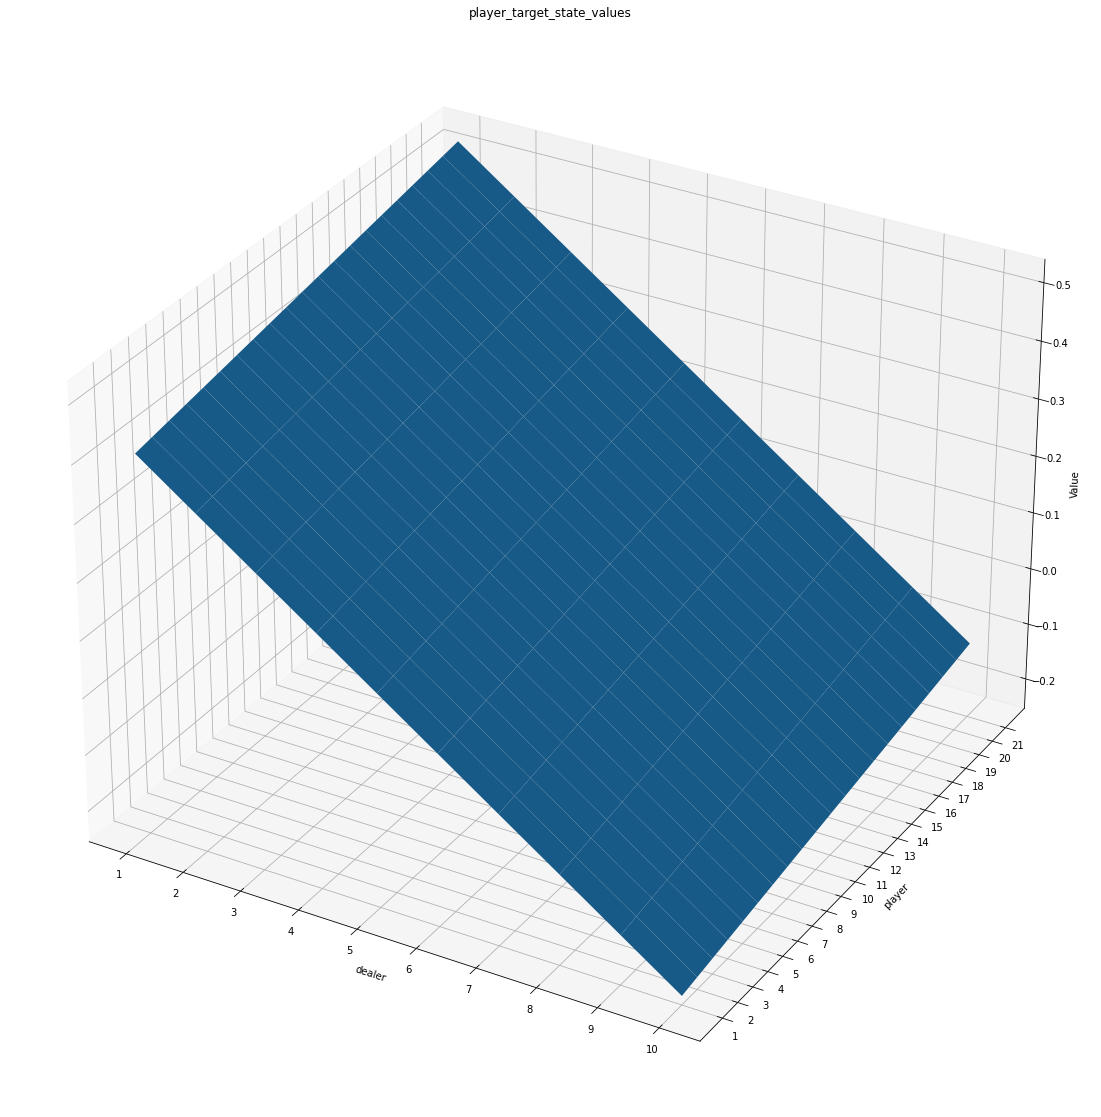

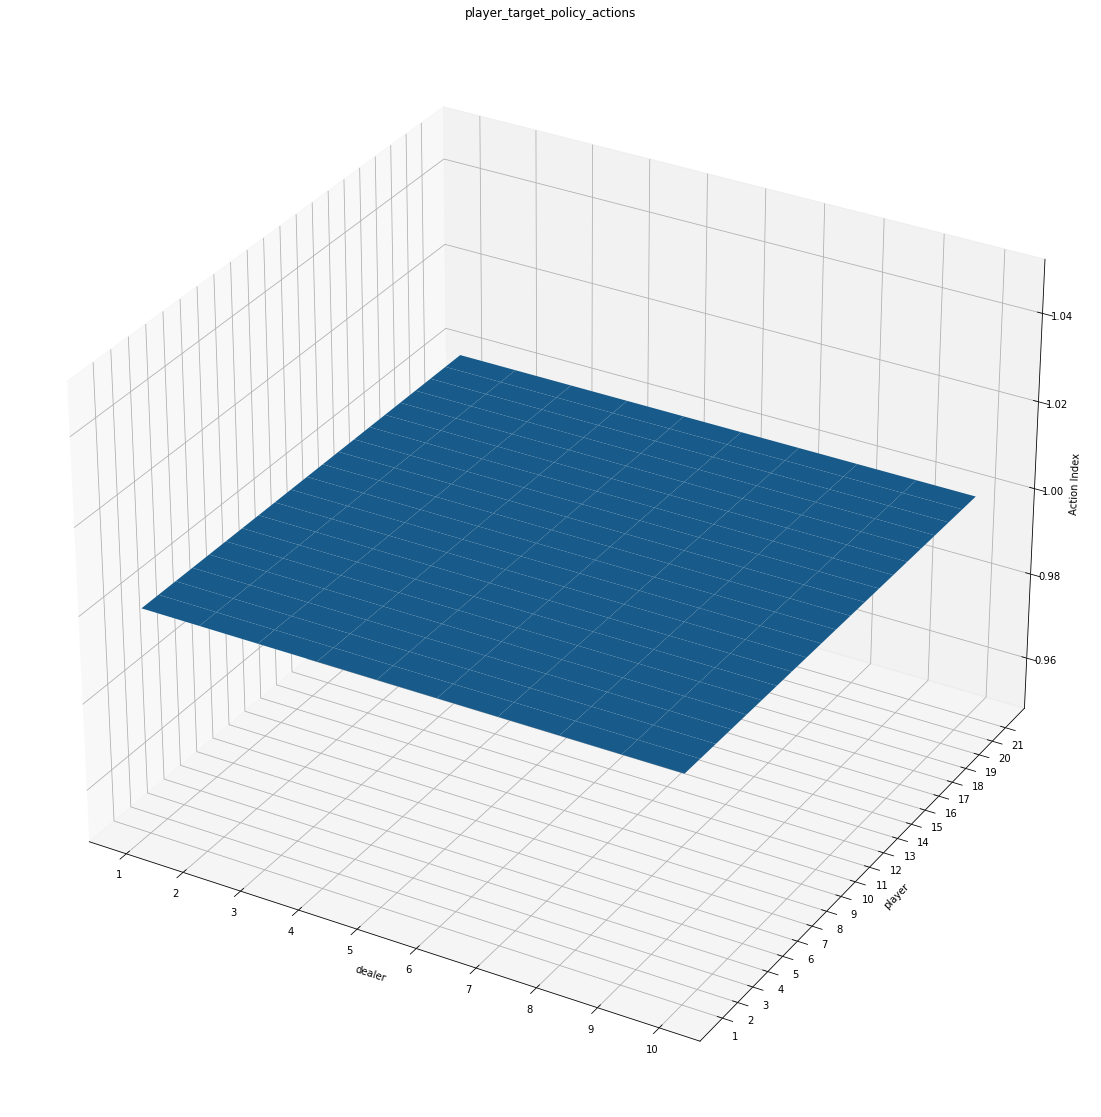

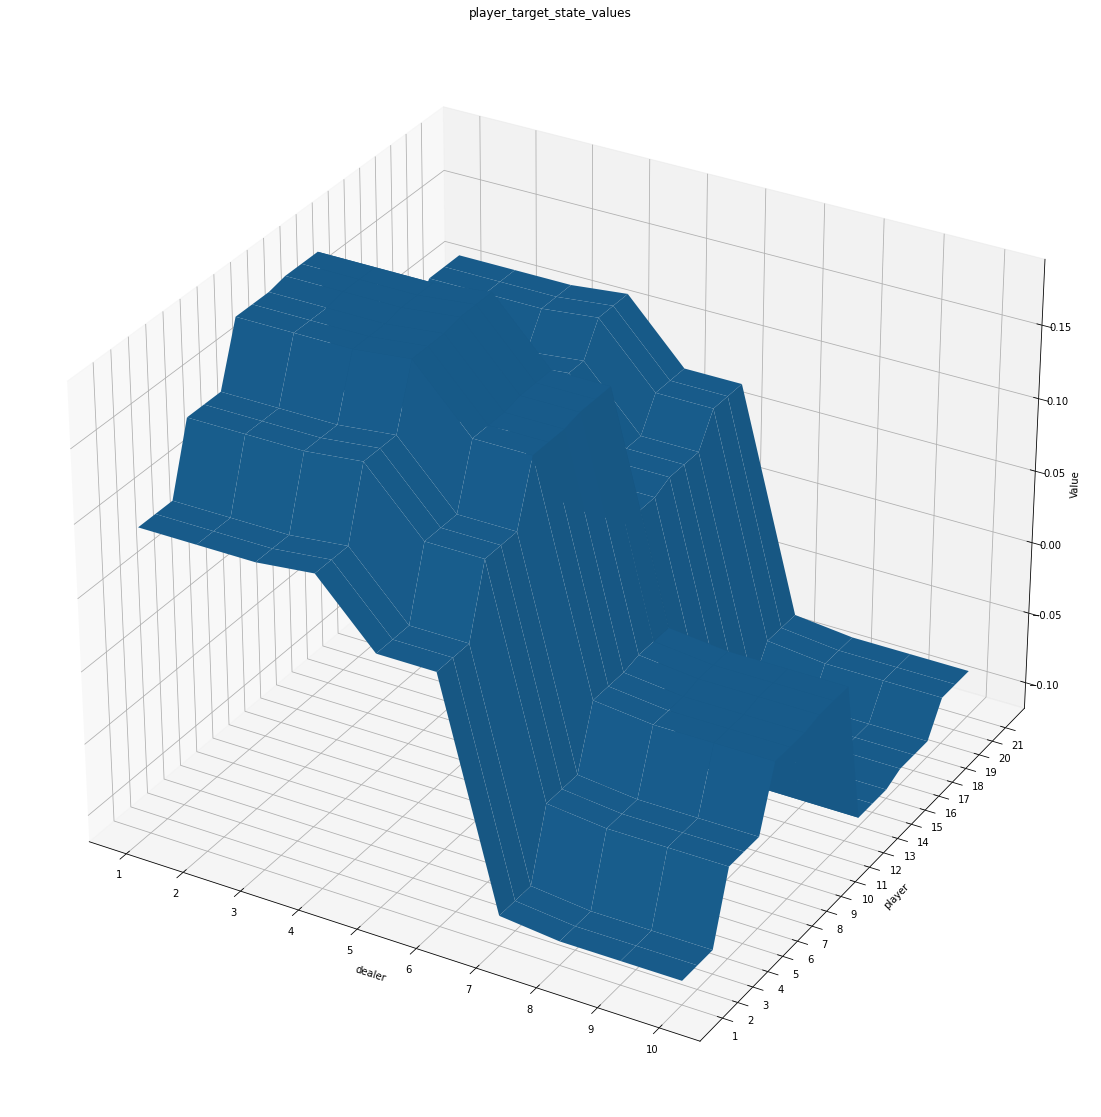

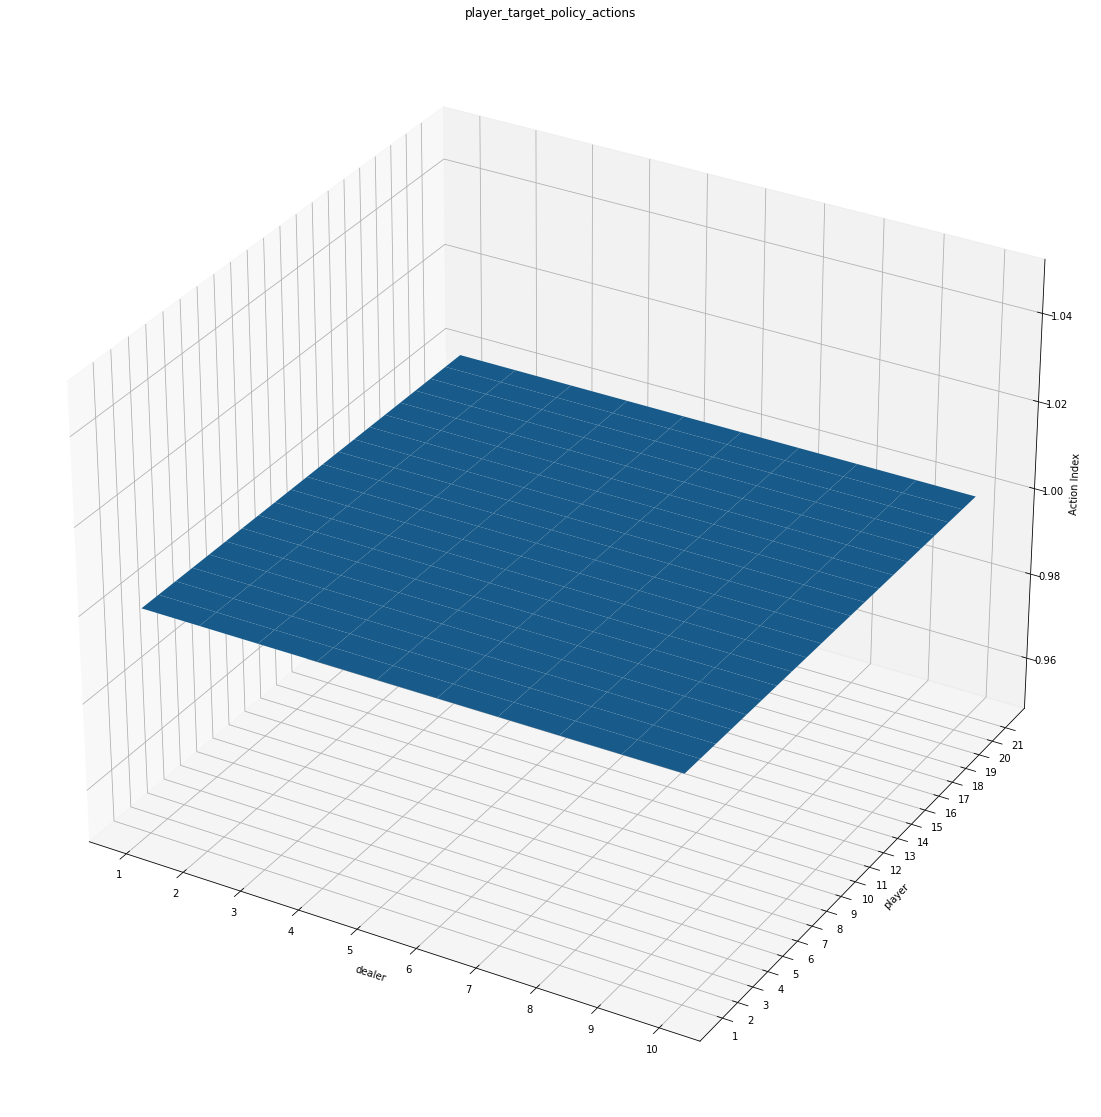

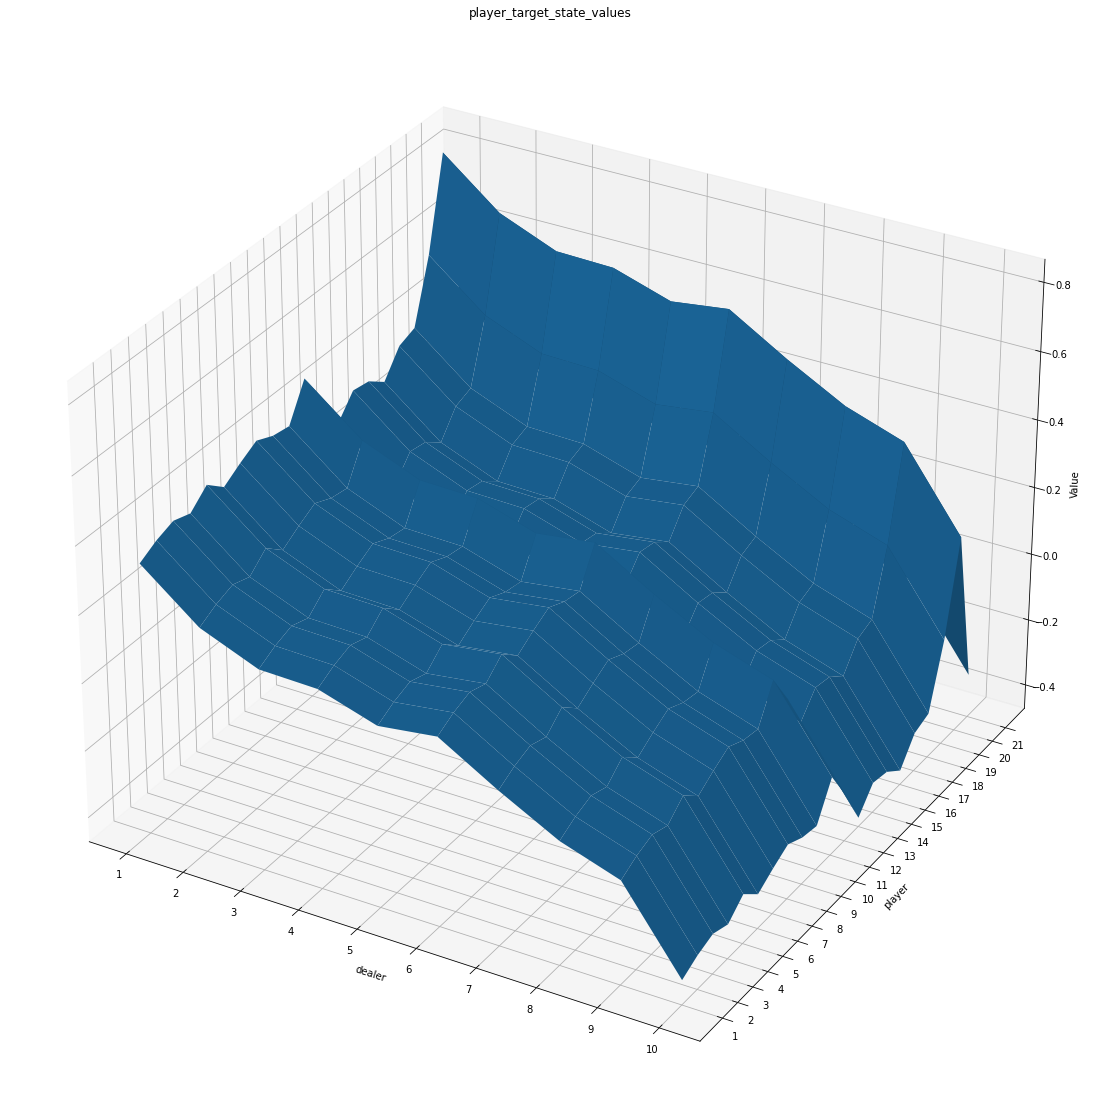

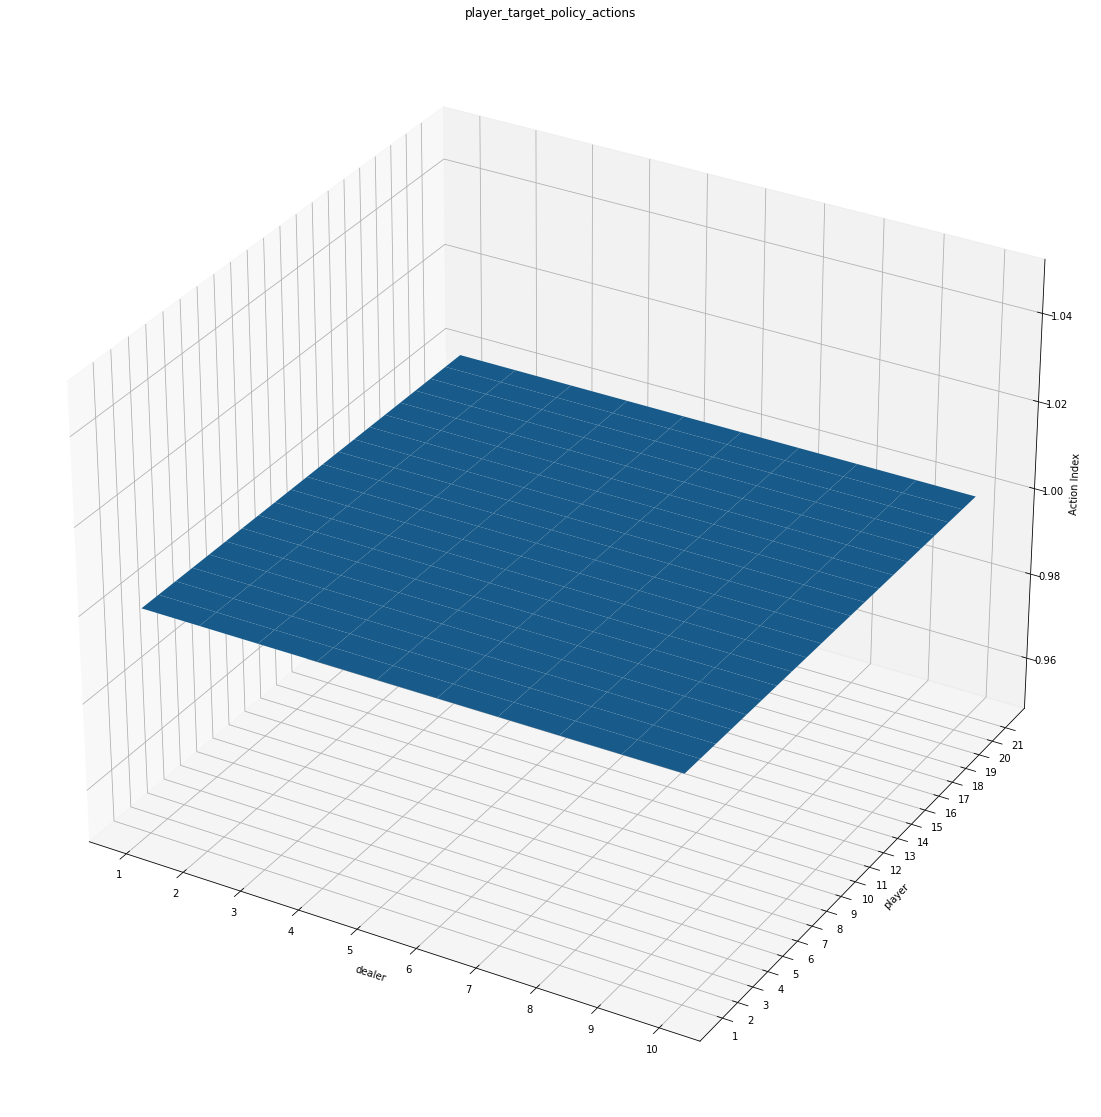

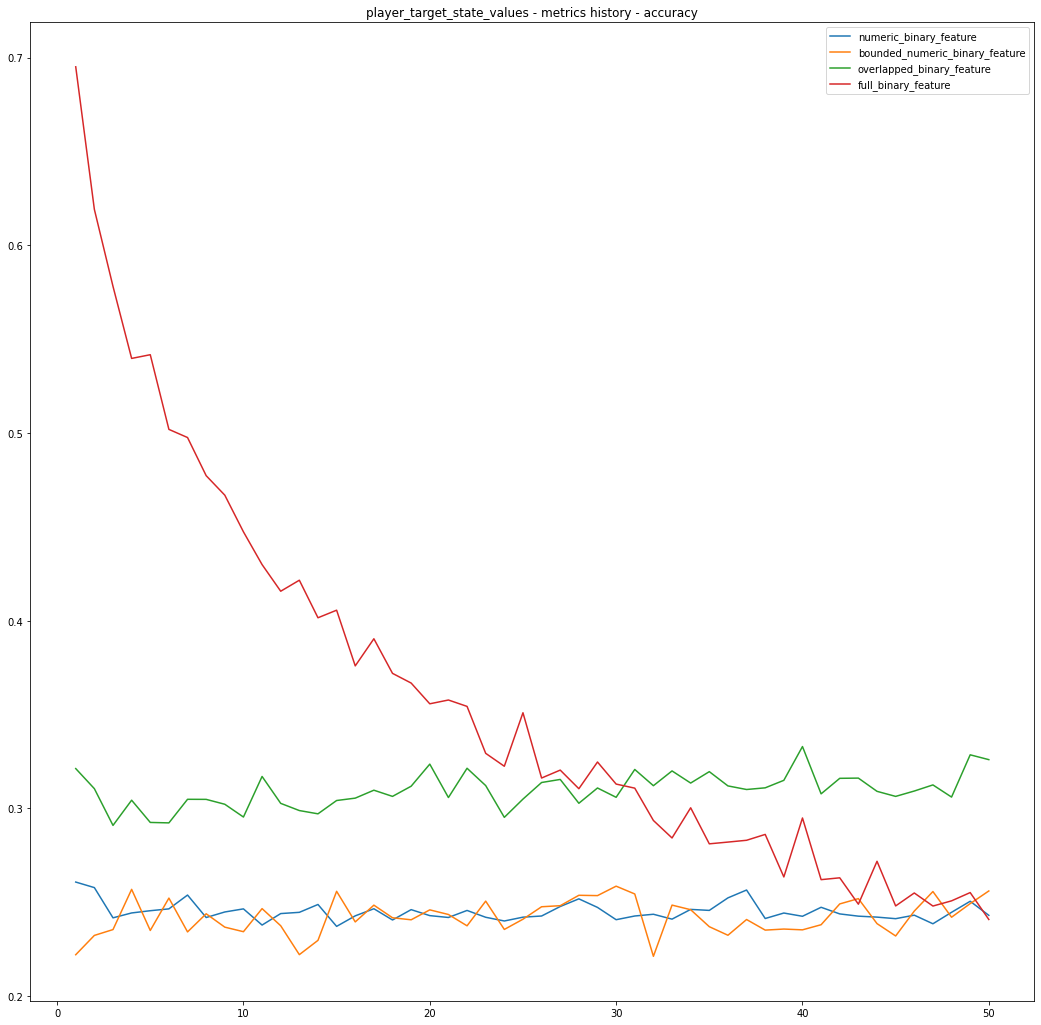

In [1]:
# TASK:
# - check binary_feature/numeric_feature ~ convergence
#
# PROCESS;
# - sample EPISODES experiences with with different feature_functions
# - replay experience of EPOCH to fit with value approximator with
#   LEARNING_RATE
# - check accuracy history
#
# RESULTS:
# - numeric_feature - best accuracy ~ 0.25
# - binary_feature - best accuracy ~ 0.30
#
# INTERPRETATION:
# - numeric_feature is creating a flat surface, while binary_feature is
#   creating a grided surface; the true value surface in this case is closer
#   to 2 surfaces combined by conditions, neural networks are expected to
#   have better accuracy
# - performance of features are dependant on particular models, in this case
#   numeric_feature shows better accuracy than binary_feature
#
# RUN:
# %%
import sys

sys.path.append("../")

from tqdm import trange
from random import shuffle

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS, STATE_LABELS, PLAYER_STATES
from src.easy_21.feature_function import (
    # numeric_feature,
    numeric_binary_feature,
    bounded_numeric_binary_feature,
    overlapped_binary_feature,
    full_binary_feature,
)

#
# hyperparameters and agent config
#
EPISODES = int(1e4)
EPOCH = 50
LEARNING_RATE = 0.001

PLAYER = ModelFreeAgent(
    "player",
    ACTIONS,
    STATE_LABELS,
    PLAYER_STATES,
    state_action_parser=full_binary_feature,
)
PLAYER.load_optimal_state_values()

PLAYER.target_state_value_store.metrics_methods[
    "accuracy"
] = PLAYER.target_state_value_store_accuracy_to_optimal

#
# process
#

for feature_function in [
    # numeric_feature,
    numeric_binary_feature,
    bounded_numeric_binary_feature,
    overlapped_binary_feature,
    full_binary_feature,
]:

    PLAYER.action_value_store.reset()
    PLAYER.action_value_store.feature_function = feature_function

    experiences = [
        playout(player_policy=PLAYER.e_greedy_policy)[0] for _ in trange(EPISODES)
    ]

    for _ in trange(EPOCH):
        shuffle(experiences)
        PLAYER.forward_td_lambda_learning_offline_batch(
            experiences, step_size=LEARNING_RATE
        )

        PLAYER.target_state_value_store.record("accuracy", log=False)

    PLAYER.target_state_value_store.stack_metrics_history("accuracy")

    PLAYER.set_target_value_stores()
    PLAYER.plot_2d_target_value_stores()

    print(PLAYER.action_value_store.weights)


labels = [
    # "numeric_feature",
    "numeric_binary_feature",
    "bounded_numeric_binary_feature",
    "overlapped_binary_feature",
    "full_binary_feature",
]
PLAYER.target_state_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
